## 6.5.2 Ridge Regression and the Lasso

In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
# warnings.filterwarnings("ignore", category=DeprecationWarning)

import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('Hitters.csv')
df.head()

df.dropna(inplace=True)
len(df)

df.head()

,Player,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,...,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,-Alan Ashby,315,81,7,24,38,39,14,3449,835,...,321,414,375,N,W,632,43,10,475.0,N
2,-Alvin Davis,479,130,18,66,72,76,3,1624,457,...,224,266,263,A,W,880,82,14,480.0,A
3,-Andre Dawson,496,141,20,65,78,37,11,5628,1575,...,828,838,354,N,E,200,11,3,500.0,N
4,-Andres Galarraga,321,87,10,39,42,30,2,396,101,...,48,46,33,N,E,805,40,4,91.5,N
5,-Alfredo Griffin,594,169,4,74,51,35,11,4408,1133,...,501,336,194,A,W,282,421,25,750.0,A


In [3]:
# prepare X (feature) and y (output)
X_num = df.select_dtypes('number').drop('Salary', axis=1)
dummies = pd.get_dummies(df[['League', 'Division', 'NewLeague']])

X = pd.concat([X_num, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)

y = df['Salary']

In [4]:
X

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,League_N,Division_W,NewLeague_N
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,632,43,10,1,1,1
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,880,82,14,0,1,0
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,200,11,3,1,0,1
4,321,87,10,39,42,30,2,396,101,12,48,46,33,805,40,4,1,0,1
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,282,421,25,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,497,127,7,65,48,37,5,2703,806,32,379,311,138,325,9,3,1,0,1
318,492,136,5,76,50,94,12,5511,1511,39,897,451,875,313,381,20,0,0,0
319,475,126,3,61,43,52,6,1700,433,7,217,93,146,37,113,7,0,1,0
320,573,144,9,85,60,78,8,3198,857,97,470,420,332,1314,131,12,0,0,0


use `combinations` from `itertools`

## Ridge Regression
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

Text(0, 0.5, 'coefficients')

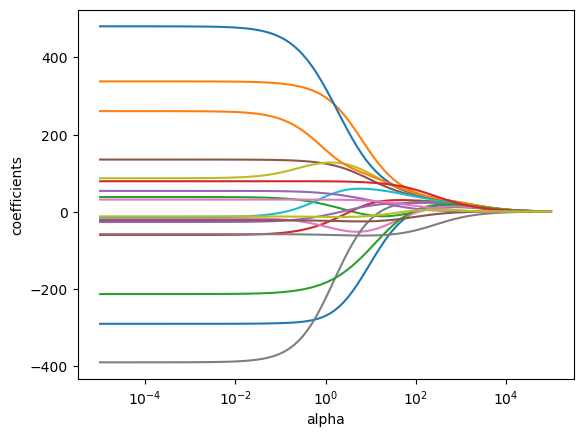

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', Ridge())
])


alphas = 10**np.linspace(-5,5,101)
coefs = []

for a in alphas:
    pipeline['regressor'].set_params(alpha=a)
    pipeline.fit(X, y)
    coefs.append(pipeline['regressor'].coef_)
    
plt.plot(alphas, coefs)
plt.gca().set_xscale('log')
# plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('coefficients')

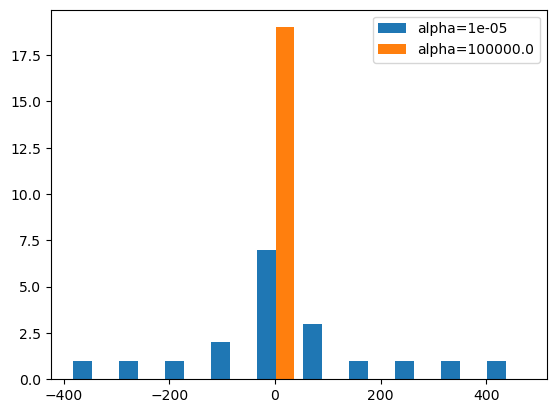

In [6]:
# len(coefs), len(coefs[0])
plt.hist([coefs[0], coefs[-1]])
plt.legend((f'alpha={alphas[0]}', f'alpha={alphas[-1]}'))

Text(0, 0.5, 'MSE')

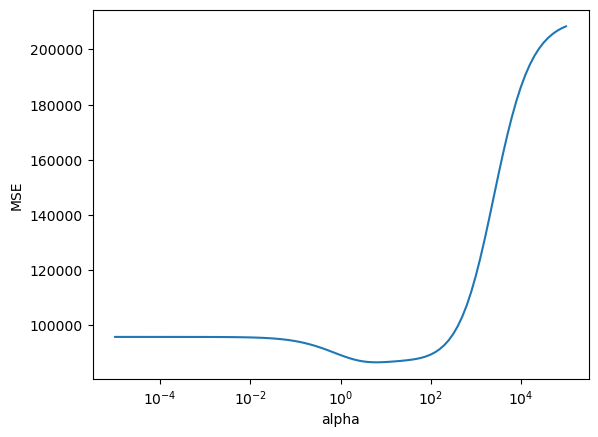

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)


mses = []
for a in alphas:
    pipeline['regressor'].set_params(alpha=a)
    pipeline.fit(X_train, y_train)
    coefs.append(pipeline['regressor'].coef_)

    mses.append(mean_squared_error(y_test, pipeline.predict(X_test)))
    
plt.plot(alphas, mses)
plt.gca().set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('MSE')

In [8]:
# cross validation using RidgeCV
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('cv', RidgeCV(alphas=alphas, scoring='neg_mean_squared_error'))
])

# model = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error', normalize=True)
pipeline.fit(X_train, y_train)
alpha_opt = pipeline['cv'].alpha_
print(alpha_opt)

1.9952623149688828


In [9]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', Ridge(alpha=alpha_opt))
])

pipeline.fit(X_train, y_train)
mean_squared_error(y_test, pipeline.predict(X_test))

87599.07594277158

In [10]:
# MSE of the null model
np.mean((y_test - np.mean(y_train))**2)

211351.87544040685

In [11]:
pipeline['regressor'].coef_

array([-209.48833569,  255.92179867,   -7.30196473,  -34.10497376,
        -17.23804451,  125.85223584,  -41.01014402, -144.50146308,
        130.22386348,   63.20287858,  292.24006756,  135.88530179,
       -233.14411458,   68.54755212,   47.07173099,  -20.30620578,
         50.93728766,  -71.47908418,  -38.1291636 ])

## The Lasso
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html

Text(0, 0.5, 'weights')

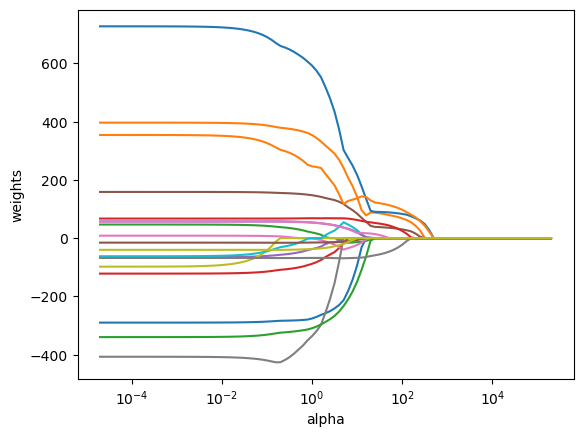

In [12]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', Lasso(max_iter=10000))
])

coefs = []

for a in alphas:
    pipeline['regressor'].set_params(alpha=a)
    pipeline.fit(X_train, y_train)
    coefs.append(pipeline['regressor'].coef_)
    
ax = plt.gca()
ax.plot(alphas*2, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

In [13]:
# cross validation using LassoCV
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('cv', LassoCV(alphas=alphas, max_iter=100000))
])

# model = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error', normalize=True)
pipeline.fit(X_train, y_train)
alpha_opt = pipeline['cv'].alpha_
print(alpha_opt)

3.1622776601683795


In [14]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', Lasso(alpha=alpha_opt, max_iter=10000))
])

pipeline.fit(X_train, y_train)
mean_squared_error(y_test, pipeline.predict(X_test))

85059.42007345003

In [15]:
pipeline['regressor'].coef_

array([-181.93171317,  207.64543193,  -15.91550617,   -0.31670454,
         -0.        ,  105.82361207,  -34.48443895,   -0.        ,
          0.        ,   46.54736779,  275.22960447,  127.67157998,
       -210.56441529,   66.96294306,   32.5431611 ,  -10.8035896 ,
         30.89896186,  -68.68472654,  -13.81163563])